Illustration of Voronoi method to separate Facial Landmarks to different AOIs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

In [13]:
### The following function is taken from https://gist.github.com/pv/8036995. 

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

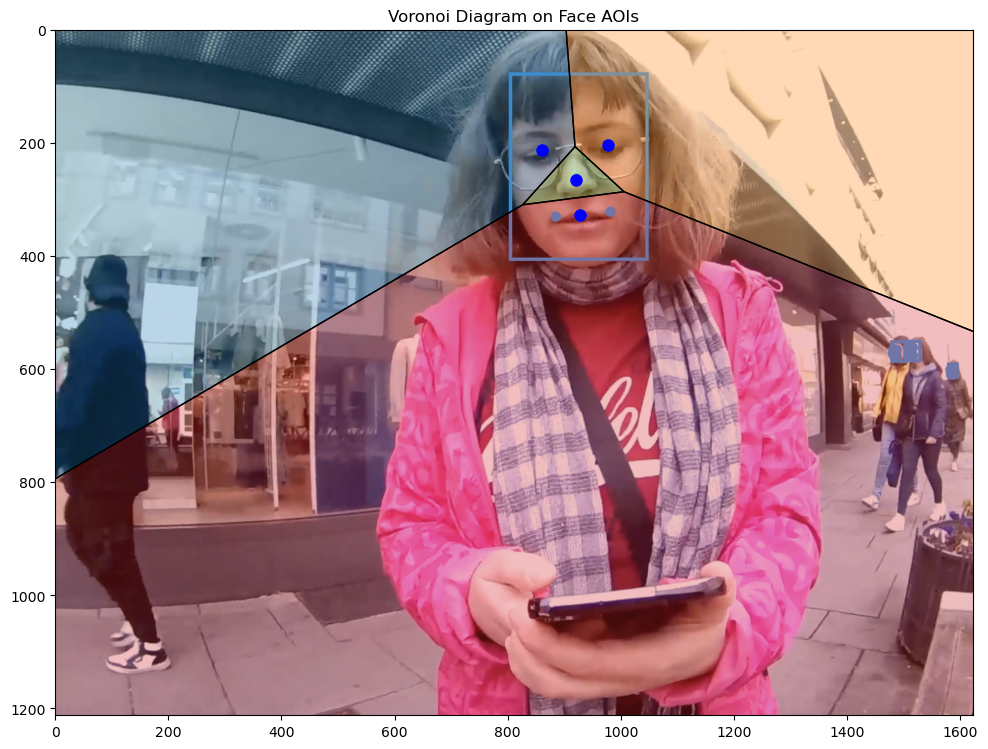

In [16]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from scipy.spatial import Voronoi

# face AOI center coordinates (on the image)
aoi_points = np.array([
    [860, 212],
    [978, 203],
    [920, 266],
    [928, 328],
])

img = mpimg.imread('/Users/alina/Downloads/Thesis/raw/12_1 1094.png')
height, width = img.shape[:2]

# compute Voronoi
vor = Voronoi(aoi_points)
regions, vertices = voronoi_finite_polygons_2d(vor, radius=5000)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img, origin='upper')

# set axis limits and direction + Y is flipped for image coordinates
ax.set_xlim(0, width)
ax.set_ylim(height, 0)

# use semi-transparent colors
colors = [mcolors.to_rgba(c, alpha=0.3) for c in mcolors.TABLEAU_COLORS.values()]

# draw Voronoi regions
for idx, region in enumerate(regions):
    polygon = vertices[region]
    patch = Polygon(polygon, facecolor=colors[idx % len(colors)],
                    edgecolor='black', linewidth=1)
    ax.add_patch(patch)

# plot AOI center points
ax.plot(aoi_points[:, 0], aoi_points[:, 1], 'bo', markersize=8)

ax.set_aspect('equal')
plt.title("Voronoi Diagram on Face AOIs")
plt.tight_layout()
plt.show()

#print("Voronoi Regions:", regions)
#print("Voronoi Vertices:\n", vertices)
